In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import triang
import random


# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate 20 random numbers from a tent distribution (using triangular distribution)
# Tent distribution with range 0.3 to 1.7 and peak at 1
c = (1 - 0.3) / (1.7 - 0.3)  # Calculate c parameter for triangular distribution
x = triang.rvs(c, loc=0.3, scale=1.4, size=20)

# Generate 20 random numbers from normal distribution with mean 0 and std dev 0.01
# z = np.random.normal(0, 0.01, 20)

# Define y = 0.8*x + z
y = 0.08 * x # + z


In [4]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add scatter points
fig.add_trace(
    go.Scatter(
        x=x, 
        y=y,
        mode='markers',
        marker=dict(
            size=12,
            color='white',
            opacity=0.7
        ),
        name='Data Points'
    )
)

# Plot the beta line
x1 = np.array([0, 2])  # x range
y1 = 0.08 * x1  # y = beta * x


# Add the Security Market Line
fig.add_trace(
    go.Scatter(
        x=x1,
        y=y1,
        mode='lines',
        line=dict(
            color='red',
            width=4
        ),
        name='Security Market Line'
    )
)

# Update layout with dark theme
fig.update_layout(
    template='plotly_dark',
    width=800,
    height=800,
    showlegend=False,
    title=dict(
        text='Security Market Line',
        x=0.5,
        y=0.95,
        xanchor='center',
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Beta',
        range=[0, 2],
        ticktext=['0', '0.5', '1', '1.5', '2'],
        tickvals=[0, 0.5, 1, 1.5, 2],
        gridcolor='gray'
    ),
    yaxis=dict(
        title='Risk Premium',
        range=[0, 0.16],
        ticktext=['0', '0.05', '0.10', '0.15'],
        tickvals=[0, 0.05, 0.1, 0.15],
        gridcolor='gray'
    ),
)

fig.update_layout(
    width=420,  # 7 inches * 100 pixels per inch
    height=300,  # 5 inches * 100 pixels per inch
    margin=dict(l=60, r=60, t=60, b=60),  # Add margins to ensure labels are visible
)
fig.show()

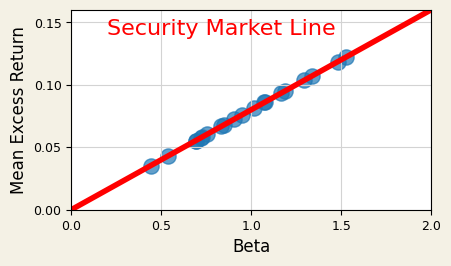

In [3]:

# Create figure with background color
fig, ax = plt.subplots(figsize=(9, 5))
fig.set_facecolor('#f4f1e5')  # Set figure/margin background color
ax.set_facecolor('white')     # Set plot area background color

# Plot scatter points
ax.scatter(x, y, s=120, alpha=0.7)

# Plot the beta line
x1 = np.array([0, 2])  # x range
y1 = 0.08 * x1  # y = beta * x
ax.plot(x1, y1, linewidth=4, color="red")

# Style settings
ax.grid(True, color='lightgray')

plt.annotate('Security Market Line', xy=(0.2, 0.14), xytext=(0.2, 0.14),
             color='red', fontsize=16)


# Set axis labels with fontsize 14
plt.xlabel('Beta', fontsize=12, family="sans-serif")
plt.ylabel('Mean Excess Return', fontsize=12)
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xticks([0, 0.5, 1, 1.5, 2])
plt.xlim(0, 2)
plt.ylim(0, 0.16)

plt.tick_params(axis='both', which='major', labelsize=9)

# Add padding around the plot while keeping square shape
plt.subplots_adjust(left=0.3, right=0.7, top=0.7, bottom=0.3)

# Save with consistent background color
plt.savefig("../posts/03-capm/capm.jpg", 
            facecolor='#f4f1e5',
            bbox_inches='tight',
            dpi=600)

In [28]:
5*626/7


447.14285714285717

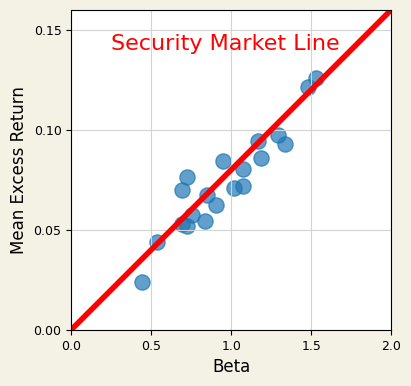

In [15]:
# Create figure with background color and adjusted margins
fig = plt.figure(figsize=(8, 8))  # Larger figure size to accommodate padding
ax = fig.add_axes([0.3, 0.3, 0.4, 0.4])  # More padding: [left, bottom, width, height]
ax.set_facecolor('white')
fig.set_facecolor('#f4f1e5')

# Plot scatter points
ax.scatter(x, y, s=120, alpha=0.7)

# Plot the beta line
x1 = np.array([0, 2])
y1 = 0.08 * x1
ax.plot(x1, y1, linewidth=4, color="red")

# Style settings
ax.grid(True, color='lightgray')

ax.annotate('Security Market Line', xy=(0.25, 0.14), xytext=(0.25, 0.14),
           color='red', fontsize=16)

# Set axis labels with fontsize 12
ax.set_xlabel('Beta', fontsize=12)
ax.set_ylabel('Mean Excess Return', fontsize=12)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_xlim(0, 2)
ax.set_ylim(0, 0.16)

ax.tick_params(axis='both', which='major', labelsize=9)

# Save with consistent background color
plt.savefig("../posts/03-capm/capm.jpg", 
            facecolor='#f4f1e5',
            bbox_inches='tight',
            dpi=300)

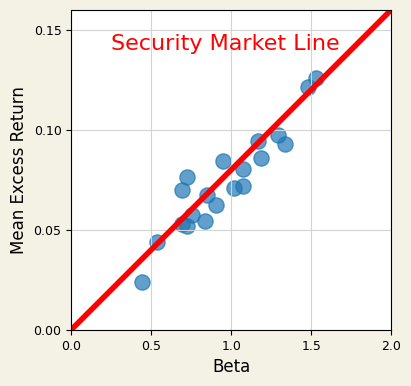

In [13]:
# Create figure with background color
fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor('#f4f1e5')  # Set figure/margin background color
ax.set_facecolor('white')     # Set plot area background color

# Plot scatter points
ax.scatter(x, y, s=120, alpha=0.7)

# Plot the beta line
x1 = np.array([0, 2])  # x range
y1 = 0.08 * x1  # y = beta * x
ax.plot(x1, y1, linewidth=4, color="red")

# Style settings
ax.grid(True, color='lightgray')

plt.annotate('Security Market Line', xy=(0.25, 0.14), xytext=(0.25, 0.14),
             color='red', fontsize=16)

# Set axis labels with fontsize 14
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Mean Excess Return', fontsize=12)
plt.yticks([0, 0.05, 0.1, 0.15])
plt.xticks([0, 0.5, 1, 1.5, 2])
plt.xlim(0, 2)
plt.ylim(0, 0.16)

plt.tick_params(axis='both', which='major', labelsize=9)


# Add padding around the plot while keeping square shape
plt.subplots_adjust(left=0.3, right=0.7, top=0.7, bottom=0.3)

# Save with consistent background color
plt.savefig("../posts/03-capm/capm.jpg", 
            facecolor='#f4f1e5',
            bbox_inches='tight',
            dpi=300)

# GET DATA

In [4]:
import pandas as pd
import yfinance as yf
from pandas_datareader import DataReader as pdr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# get monthly market excess return and risk-free rate for past 60 months from French's data library
ff = pdr('F-F_Research_Data_Factors','famafrench',start=2017)[0]
ff = ff.iloc[-60:]

# get mean annual market excess return since 1926 from French's data library
mprem = pdr('F-F_Research_Data_Factors','famafrench',start=1926)[1]['Mkt-RF'].mean()

# get current 3-month Treasury bill yield from FRED
rf = pdr('DGS3MO','fred',start=2022).iloc[-1].item()

# pull data from yahoo for ticker
ret = yf.download(
    ticker,
    start='2017-01-01',
    progress=False,
    auto_adjust=False
  )['Adj Close']
ret = ret.resample('M').last().pct_change()*100
ret.index = ret.index.to_period('M')
ret.columns = ["ret"]

# merge with French data, reducing to 60 months in the process
df = ff.join(ret,how='left')

# compute excess returns for the ticker
df['ret'] -= df.RF

# RUN MARKET MODEL REGRESSION

In [5]:
import statsmodels.api as sm

# run regression of excess return on market excess return and get beta
result = sm.OLS(df.ret,sm.add_constant(df['Mkt-RF'])).fit()
beta = result.params['Mkt-RF']

# CALCULATE COST OF EQUITY

In [6]:
# compute cost of equity
eret = rf + beta*mprem


print(f'Beta:\t\t\t{beta:.2f}')
print(f'Market Risk Premium:\t{mprem:.2f}')
print(f'{ticker} Risk Premium:\t{beta*mprem:.2f}')
print(f'Risk-free Rate:\t\t{rf:.2f}')
print(f'{ticker} Cost of Equity:\t{eret:.2f}')

Beta:			0.51
Market Risk Premium:	8.80
WMT Risk Premium:	4.46
Risk-free Rate:		4.34
WMT Cost of Equity:	8.80


# FIGURE

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df[["Mkt-RF", "ret"]].reset_index()
df.columns = ["date", "mkt", "ret"]
df["date"] = df.date.astype(str)


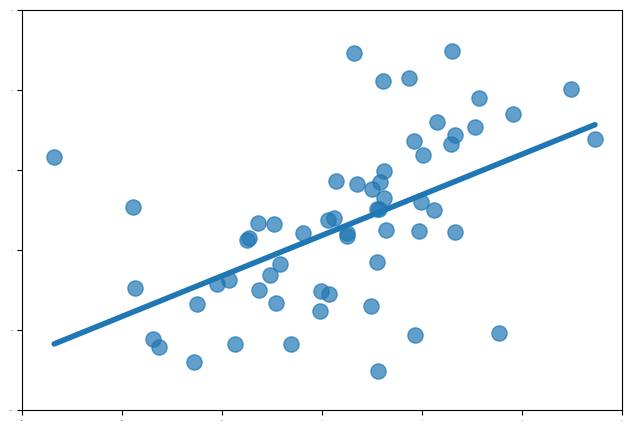

In [8]:
fig, ax = plt.subplots(figsize=(6, 4)) 
sns.set_style("whitegrid", {'axes.facecolor': '#f4f1e5'})
# Set the style parameters for the regression plot
# Increase line thickness and marker size
sns.set_context("notebook", font_scale=1.2)
# Define custom parameters for the regression plot
scatter_kws = {'s': 120, 'alpha': 0.7}  # Larger markers (s controls size)
line_kws = {'lw': 4}   # Thicker line (lw controls width)


sns.regplot(x=df.mkt, y=df.ret, ci=False, ax=ax,
            scatter_kws=scatter_kws, line_kws=line_kws)
# Set axis labels with larger font size
ax.set_xlabel(None)
ax.set_ylabel(None)
# Set axis limits to (-15, 15)
ax.set_xlim(-15, 15)
ax.set_ylim(-10, 15)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)




# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=0)
plt.savefig("../posts/03-capm/capm.jpg")



In [9]:
import plotly.express as px


df['mkt'] = df['mkt']/100
df['ret'] = df['ret']/100

fig = px.scatter(
    df,
    x="mkt",
    y="ret",
    trendline="ols",
    hover_data=dict(ret=False, mkt=False, date=False),
    hover_name="date",
)

fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=2, color="DarkSlateGrey")
    ),
    selector=dict(mode="markers"),
)

fig.update_layout(
    xaxis_title="Market Excess Return",
    yaxis_title=ticker.upper() + " Excess Return",
    xaxis_tickformat=".0%",
    yaxis_tickformat=".0%",
    template="plotly"
)
fig.show()

In [10]:
fig.write_image("../posts/05-capm/capm.jpg", width=800, height=500)

FileNotFoundError: [Errno 2] No such file or directory: '..\\posts\\05-capm\\capm.jpg'